In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from typing import List, Tuple

print('OpenCV Version: ', cv2.__version__)

OpenCV Version:  4.3.0


It seems like OpenCV's canny edge detector exhibits really different behaviors across versions. Or maybe it's a Windows vs Mac thing. Anyway I need a different way to segment the game fields.

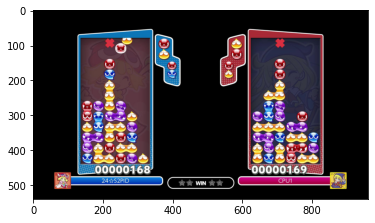

In [25]:
im = Image.open('test-images/amitie_witch2.jpg')
im = im.resize((im.width // 2, im.height // 2))
im = np.array(im)
plt.imshow(im)
plt.show()

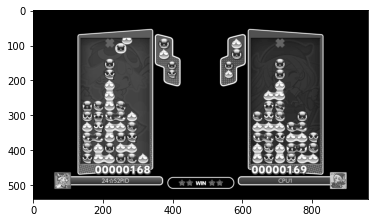

In [26]:
# Grayscale
im_gray = np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])
im_gray = im_gray.astype(np.uint8)
plt.imshow(im_gray, cmap='gray')
plt.show()

## 1. Contrast Stretch using lookup table

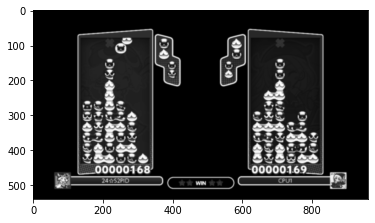

In [27]:
# Use a lookup table to apply contrast stretching to dark regions
xp = [0, 64, 128, 192, 255]
fp = [0, 32, 64, 240, 255]
x = np.arange(256)
table = np.interp(x, xp, fp).astype('uint8')
new_im = table[im_gray]
new_im = cv2.GaussianBlur(new_im, (5, 5), 0)
plt.imshow(new_im, cmap='gray')
plt.show()

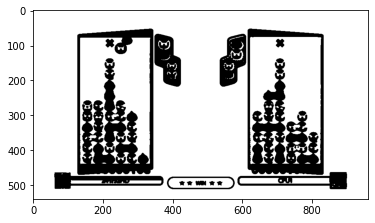

In [28]:
# Get a mask for dark regions
mask = np.zeros_like(new_im)
mask[new_im < 40] = 255
plt.imshow(mask, cmap='gray')
plt.show()

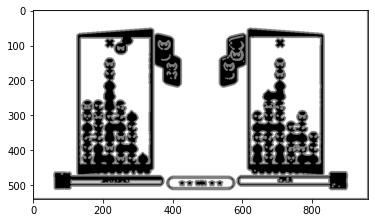

In [29]:
contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
mask_copy = np.copy(mask)
cv2.drawContours(mask_copy, contours, -1, 128, 3)
plt.imshow(mask_copy, cmap='gray')

[[1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]]


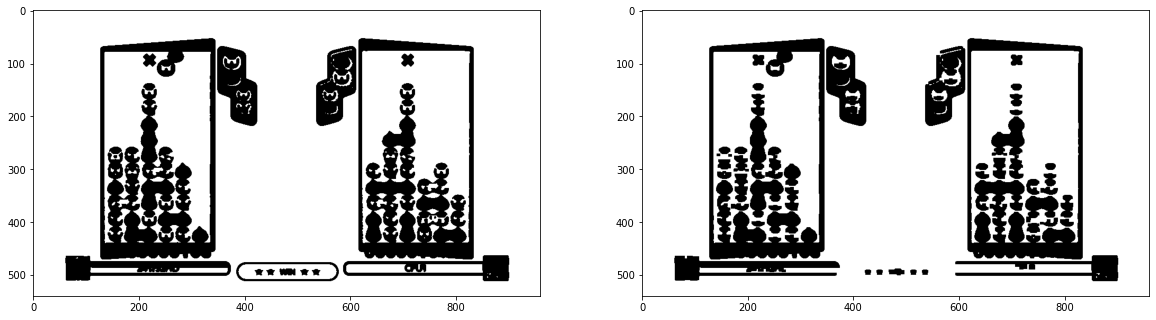

In [30]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 5))
print(kernel)
closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
fig, ax = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(20)
ax[0].imshow(mask, cmap='gray')
ax[1].imshow(closed, cmap='gray')
plt.show()

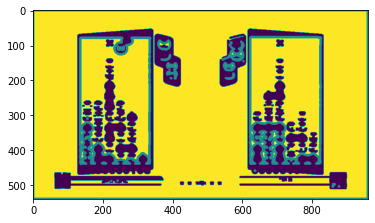

In [31]:
contours, hierarchy = cv2.findContours(closed, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# Only keep contours that outline white regions
hierarchy = hierarchy.reshape(-1, 4)
top_inds = np.argwhere(hierarchy[:, 3] == -1).reshape(-1)
contours = [contours[i] for i in top_inds]
hierarchy = hierarchy[top_inds]

closed_copy = np.copy(closed)
cv2.drawContours(closed_copy, contours, -1, 128, 5)
plt.imshow(closed_copy, cmap='viridis')

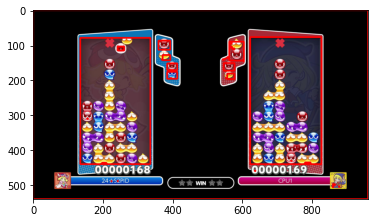

In [33]:
# Find bounding rects for each contour
rects = np.array([cv2.boundingRect(contour) for contour in contours])
rect_contour = [np.array([[[x, y]], [[x, y + h]], [[x + w, y + h]], [[x + w, y]]]) for x, y, w, h in rects]
im_copy = np.copy(im[..., :3])
cv2.drawContours(im_copy, rect_contour, -1, (255, 0, 0), 3)
plt.imshow(im_copy)

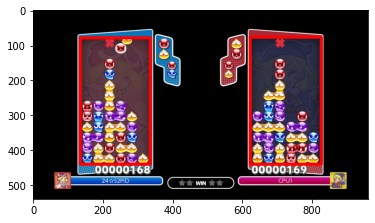

In [34]:
def pairwise_dist(x: np.ndarray) -> np.ndarray:
    """
    Calculate pairwise distances between data points.
    The main diagonal of the output is set to infinity so that
    running np.min(x) will ignore the distance to itself, which would
    always be trivially zero.
    """
    diff = x[np.newaxis, : , :] - x[:, np.newaxis, :]
    norm = np.linalg.norm(diff, 2, -1)
    dist = norm.transpose()
    np.fill_diagonal(dist, np.infty)
    return dist

def field_rois(rects: np.ndarray, aspect_ratio=0.5333, threshold=0.1):
    """
    Extract a pair of ROIs that have a Width/Height ratio of 0.5333, like
    a normal game field. If a pair isn't found, the function returns None
    """
    # Sort field_rois by largest area
    areas = rects[:, 2] * rects[:, 3]
    rects = rects[np.argsort(-areas)]
    
    widths = rects[:, 2]
    heights = rects[:, 3] + 1e-8 # Avoid divide by 0 errors
    aspect_ratios = widths / heights

    # Calculate percent difference to expected aspect ratio
    field_ar_pdiff = (aspect_ratios - aspect_ratio) / ((aspect_ratios + aspect_ratio) / 2)

    # Get the rects for contours that have <5% difference
    game_fields = rects[field_ar_pdiff < threshold]

    # Get only the 2 that have the smallest distance between their y-pos, width, and height
    dists = pairwise_dist(game_fields[:, 1:4])
    paired_inds = np.array(np.unravel_index(np.argmin(dists), dists.shape))
    game_field_rois = game_fields[paired_inds]
    
    # Sort it so Player 1 (lowest X value) is first
    game_field_rois = game_field_rois[np.argsort(game_field_rois[:, 0]), :]

    return game_field_rois

# Find player fields based on aspect ratio
fields = field_rois(rects)
rect_contour = [np.array([[[x, y]], [[x, y + h]], [[x + w, y + h]], [[x + w, y]]]) for x, y, w, h in fields]
im_copy = np.copy(im[..., :3])
cv2.drawContours(im_copy, rect_contour, -1, (255, 0, 0), 8)
plt.imshow(im_copy)

In [113]:
def player_field_rois(im: np.ndarray, return_im=False):
    # Grayscale
    im_gray = np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])
    im_gray = im_gray.astype(np.uint8)

    # Contrast Stretching
    xp = [0, 64, 128, 192, 255]
    fp = [0, 32, 64, 240, 255]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    new_im = table[im_gray]
    new_im = cv2.GaussianBlur(new_im, (5, 5), 0)

    # Get a mask for dark regions
    mask = np.zeros_like(new_im)
    mask[new_im < 40] = 255

    # Try to merge nearby contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Get the contours
    contours, hierarchy = cv2.findContours(closed, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    # Only keep contours that outline white regions
    hierarchy = hierarchy.reshape(-1, 4)
    top_inds = np.argwhere(hierarchy[:, 3] == -1).reshape(-1)
    contours = [contours[i] for i in top_inds]
    hierarchy = hierarchy[top_inds]

    # Find bounding rects for each contour
    rects = np.array([cv2.boundingRect(contour) for contour in contours])
    rect_contour = [np.array([[[x, y]], [[x, y + h]], [[x + w, y + h]], [[x + w, y]]]) for x, y, w, h in rects]
    im_copy = np.copy(im[..., :3])
    cv2.drawContours(im_copy, rect_contour, -1, (255, 0, 0), 8)

    # Filter ROIs that should belong to player fields
    fields = field_rois(rects)

    if return_im:
        rect_contour = [np.array([[[x, y]], [[x, y + h]], [[x + w, y + h]], [[x + w, y]]]) for x, y, w, h in fields]
        im_copy = np.copy(im[..., :3])
        cv2.drawContours(im_copy, rect_contour, -1, (255, 0, 0), 8)
        return fields, im_copy
    
    return fields


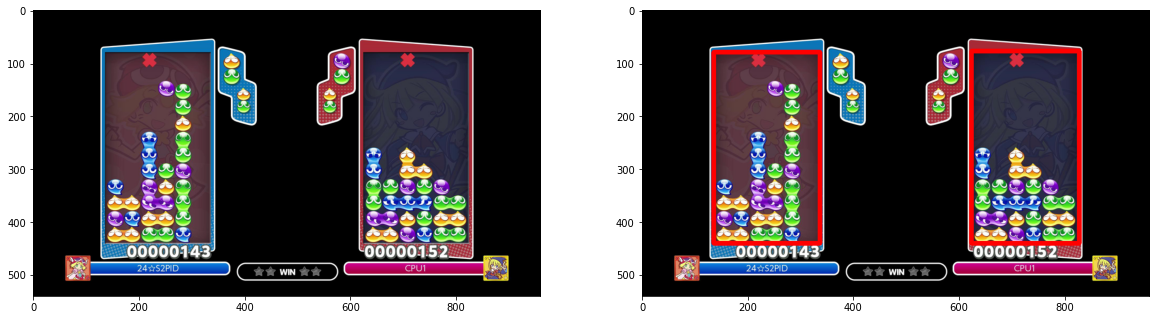

In [114]:
test_im = Image.open('test-images/amitie_witch3.jpg')
test_im = test_im.resize((960, 540))
test_im = np.array(test_im)
fields, marked = player_field_rois(test_im, return_im=True)
fig, ax = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(20)
ax[0].imshow(test_im)
ax[1].imshow(marked)
plt.show()